In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim import corpora, models
from gensim.models import LdaMulticore
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [2]:
#상수
PATH = '../data/lda_data.csv'
OUTPUT = '../lda_vis.html'
PICTURE = '../picture/'
TEST = 5
TOPIC = 6
SAMPLE = 5

In [3]:
#분할
def make_data(path, test_count):
    # 사전은 전체데이터로 구성
    df = pd.read_csv(path)
    docs = df['Abstract'].apply(lambda x: x.strip().split()).tolist()
    dic = corpora.Dictionary(docs)
    # x, y 분할
    y = df.sample(n=test_count, random_state=42)
    x = df.drop(y.index)
    return x.reset_index(drop=True), y.reset_index(drop=True), dic

#모델 요구 형식 반환
def make_model_input(df, dic):
    docs = df['Abstract'].apply(lambda x: x.strip().split()).tolist()
    return [dic.doc2bow(t) for t in docs]

In [ ]:
def learn_visualize(corpus, dictionary):
    #LDA 멀티코어 학습
    model = LdaMulticore(corpus = corpus,
                         id2word = dictionary,
                         num_topics = TOPIC, # 원하는 토픽 수
                         random_state = 42,
                         passes = 50,        # 코퍼스 단위 학습 반복 횟수
                         iterations = 50,    # 문서 단위 학습 반복 횟수
                         workers = 6,        # CPU 코어 수
                         per_word_topics = True )
    #pyLDAvis 시각화
    vis_data = gensimvis.prepare(model, corpus, dictionary)
    pyLDAvis.save_html(vis_data, OUTPUT)
    pyLDAvis.display(vis_data)

    #시각화 정보에 맞게 매핑
    vis_map = {k:v for k, v in enumerate(vis_data.topic_order)}

    return model, vis_map

#문서리스트의 대응 토픽(시각화 기준) 반환
def topic_list(model_input, model, topic_vis_map):
    return [topic_vis_map[max(i, key=lambda x: x[1])[0]] for i in model.get_document_topics(model_input)]

In [5]:
#학습한 토픽 별 제목 뽑기
def print_train_sample_topic_title(df, topic, sample):
    df = pd.DataFrame({'Title':df['Article Title'], 'Topic':topic})
    #n개 뽑아 출력
    print('Train Data')
    for i in list(range(1, TOPIC + 1)):
        print(f'Topic {i}')
        temp = df.loc[df['Topic'] == i, 'Title'].sample(n=sample).array
        for t in temp:
            print(t)
        print()

#테스트 데이터 결과 출력
def print_test_topic_title(df, topic):
    print('Test Data')
    print('Topic : Title')
    for i in range(len(topic)):
        print(f'{topic[i]} : {df.iloc[i, 0]}')
    print()

In [6]:
#연구 추세 그래프 출력 
def make_time_plot(data, topic):
    df = pd.DataFrame({'Date':data['Date'], 'Topic':topic})
    df['Date'] = pd.to_datetime(df['Date']).dt.to_period('M').astype(str)
    df = df.groupby(['Date', 'Topic']).size().unstack(fill_value=0)
    
    def save_show(plot, fime_name):
        plot.set_xticks(range(len(df.index)))
        plot.set_xticklabels(df.index, rotation=90)
        plt.title('Monthly Topic Trends')
        plt.xlabel('Date')
        plt.ylabel('Document Count')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.savefig(f'{PICTURE}{fime_name}.png')
        plt.show()

    topic_iter = list(range(1, TOPIC + 1))
    
    plot = df.plot(y=topic_iter, legend=True, figsize=(20, 10))
    save_show(plot, 'total')

    for i in topic_iter:
        plot = df.plot(y=i, legend=True, figsize=(20, 10))
        save_show(plot, str(i))

Train Data
Topic 1
Fractal Augmented Pre-training and Gaussian Virtual Feature Calibration for Tackling Data Heterogeneity in Federated Learning
Semisupervised Federated-Learning-Based Intrusion Detection Method for Internet of Things
Federated Time-Dependent GNN Learning from Brain Connectivity Data with Missing Timepoints
Collaborative Learning With Heterogeneous Local Models: A Rule-Based Knowledge Fusion Approach
Federated-Learning-Based Synchrotron X-Ray Microdiffraction Image Screening for Industry Materials

Topic 2
Fully-distributed optimization with Network Exact Consensus-GIANT
Mitigating bias in heterogeneous federated learning via stratified client selection
Semi-Asynchronous Federated Learning with Trajectory Prediction for Vehicular Edge Computing
Adaptive client selection with personalization for communication efficient Federated Learning
Resource-Aware Hierarchical Federated Learning for Video Caching in Wireless Networks

Topic 3
Horizontal Federated Recommender System

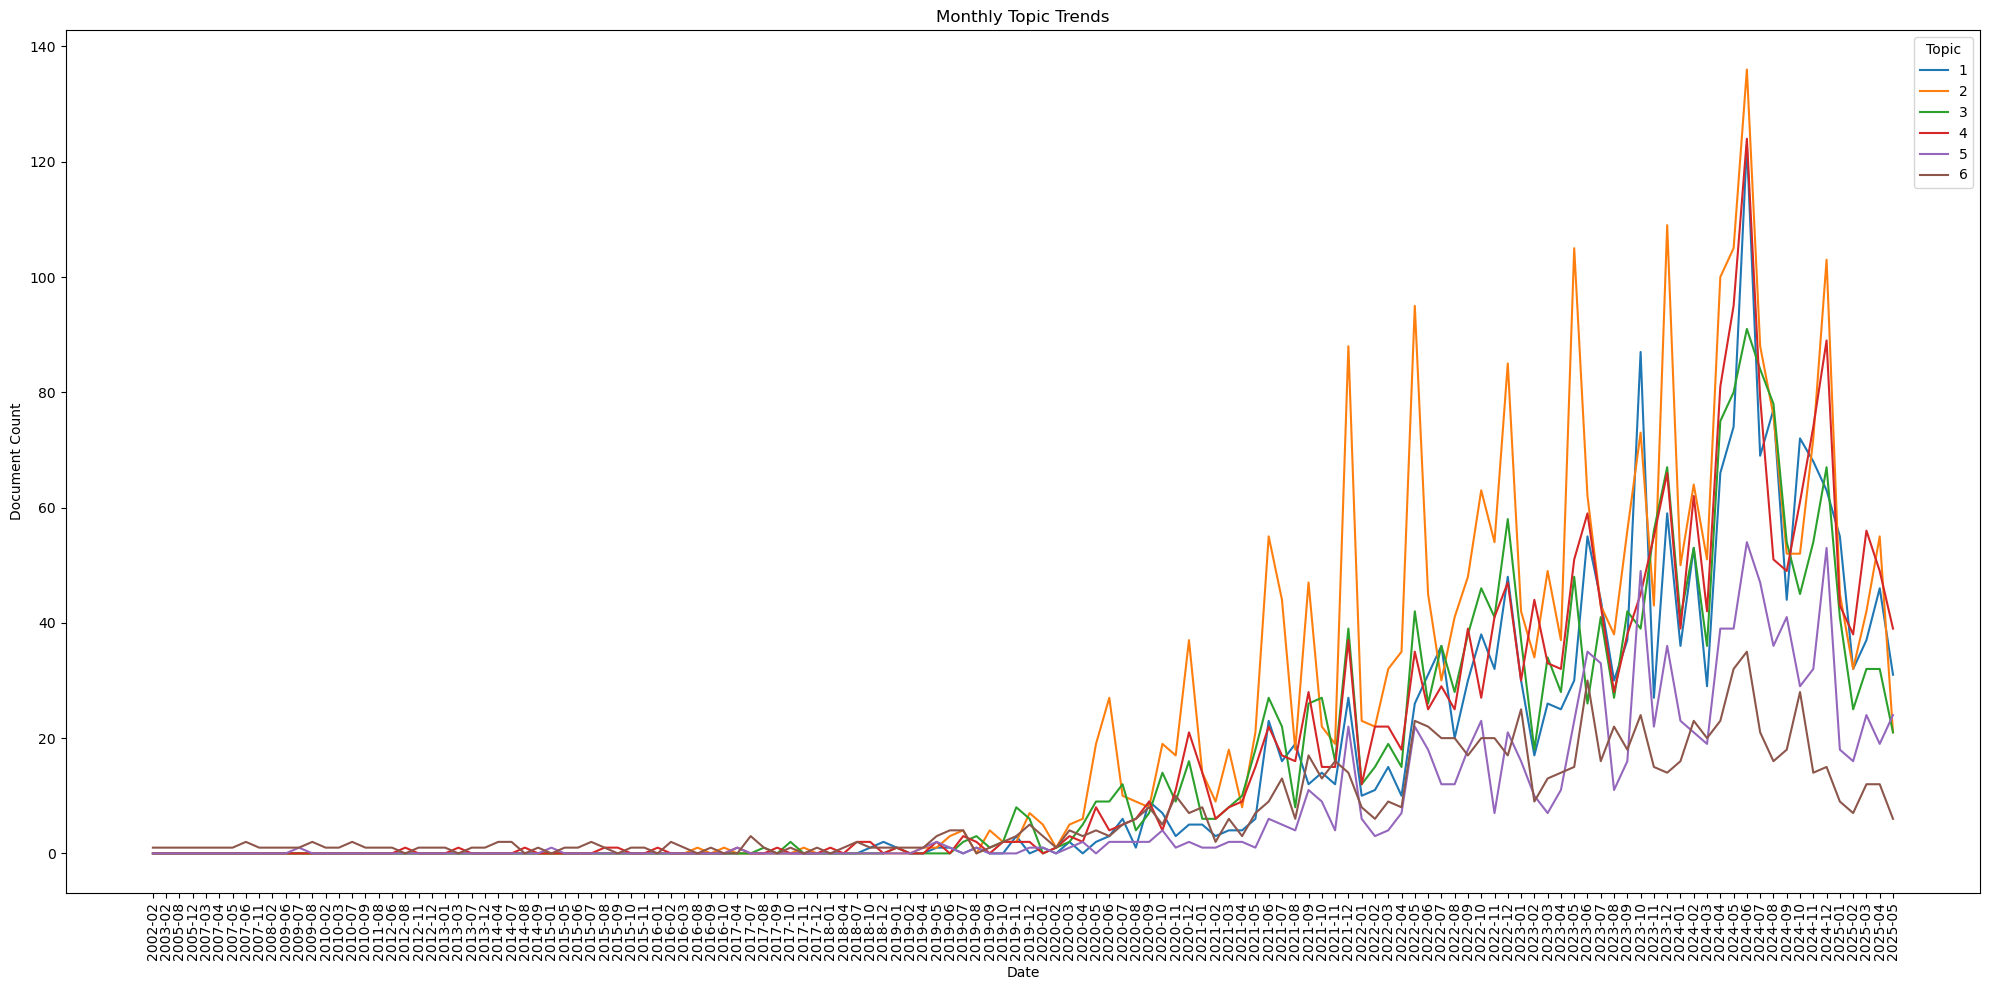

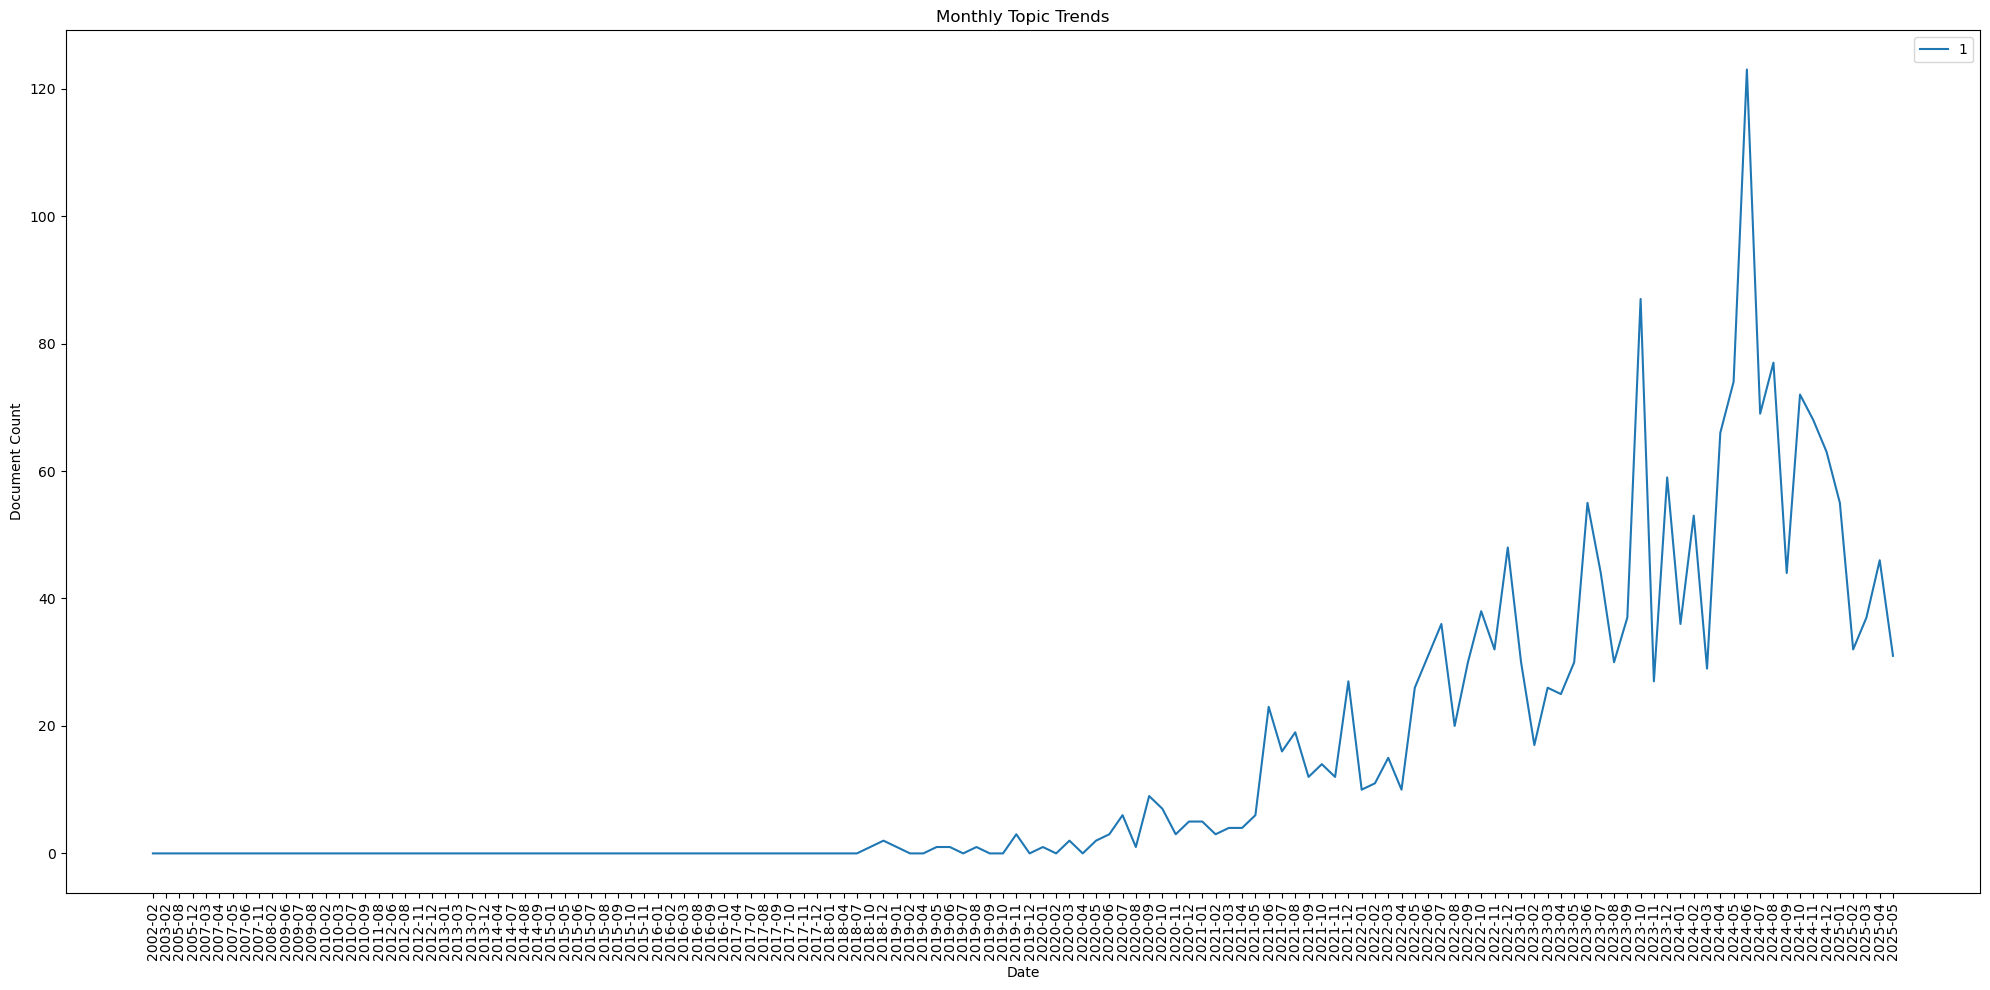

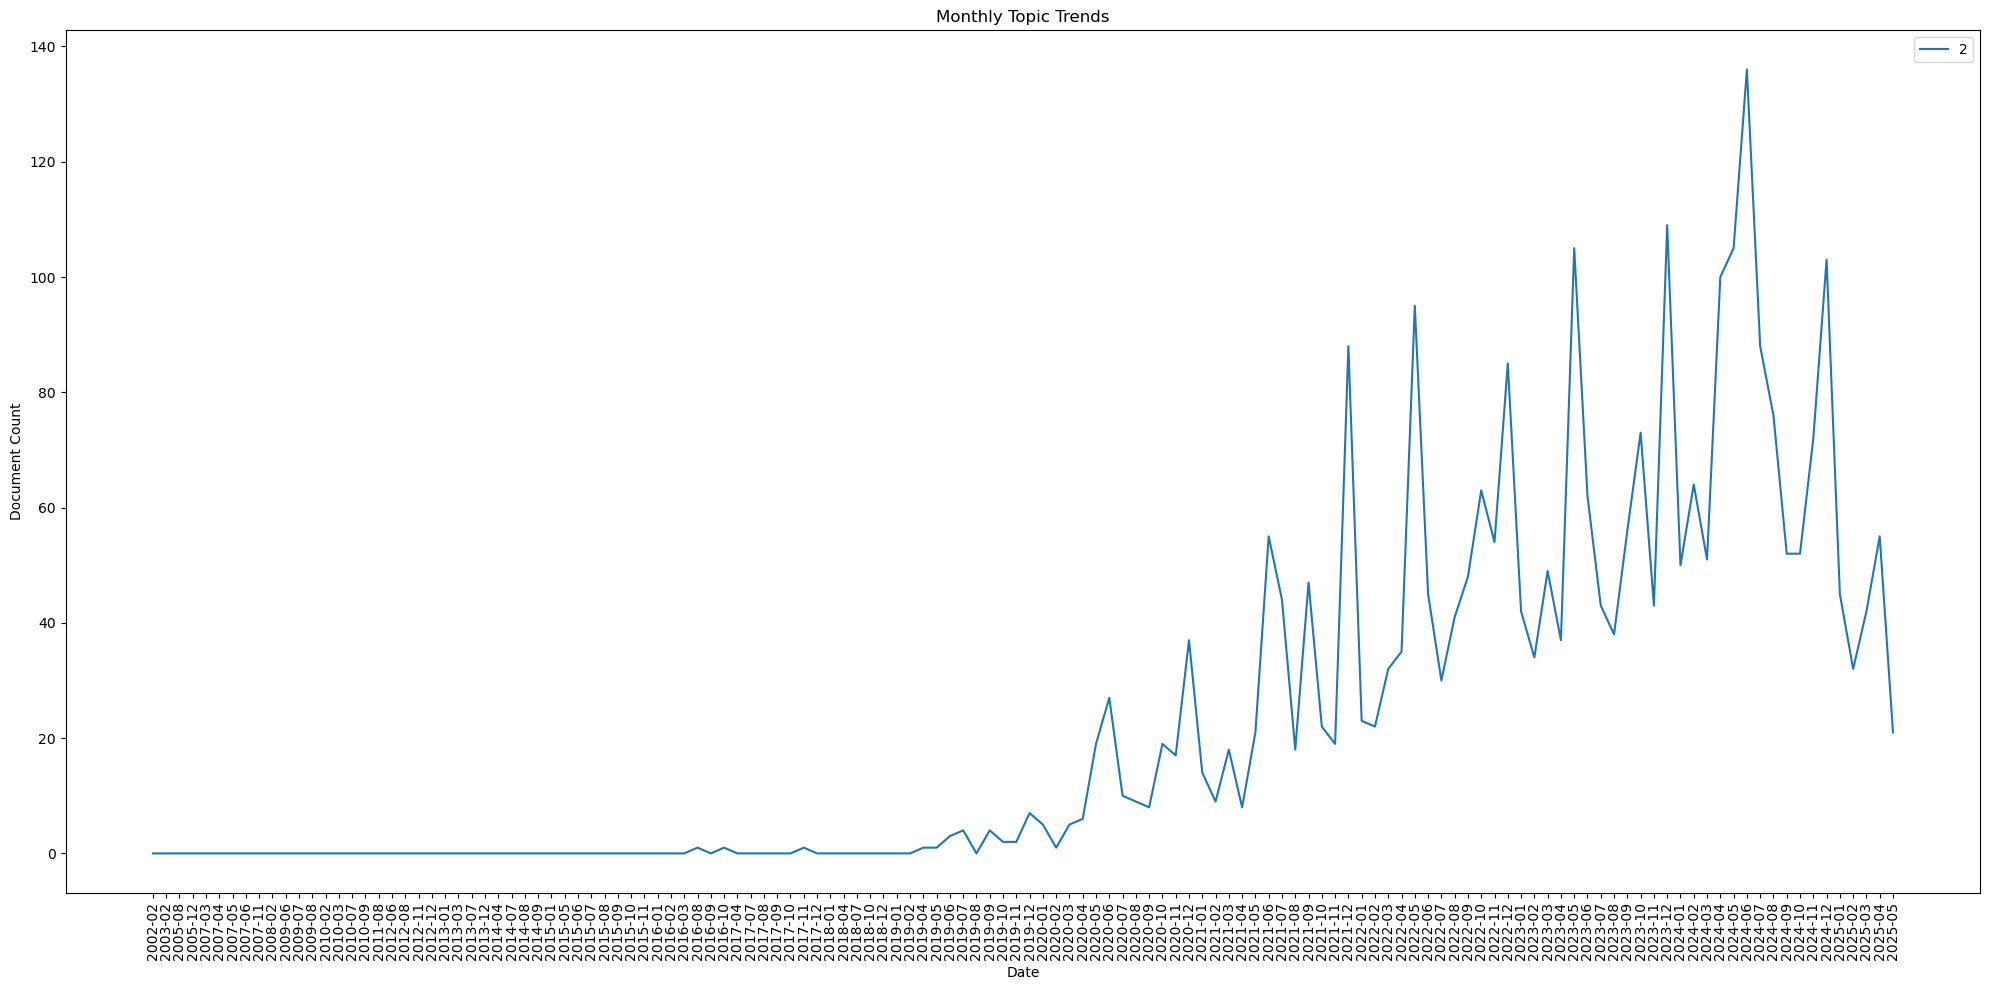

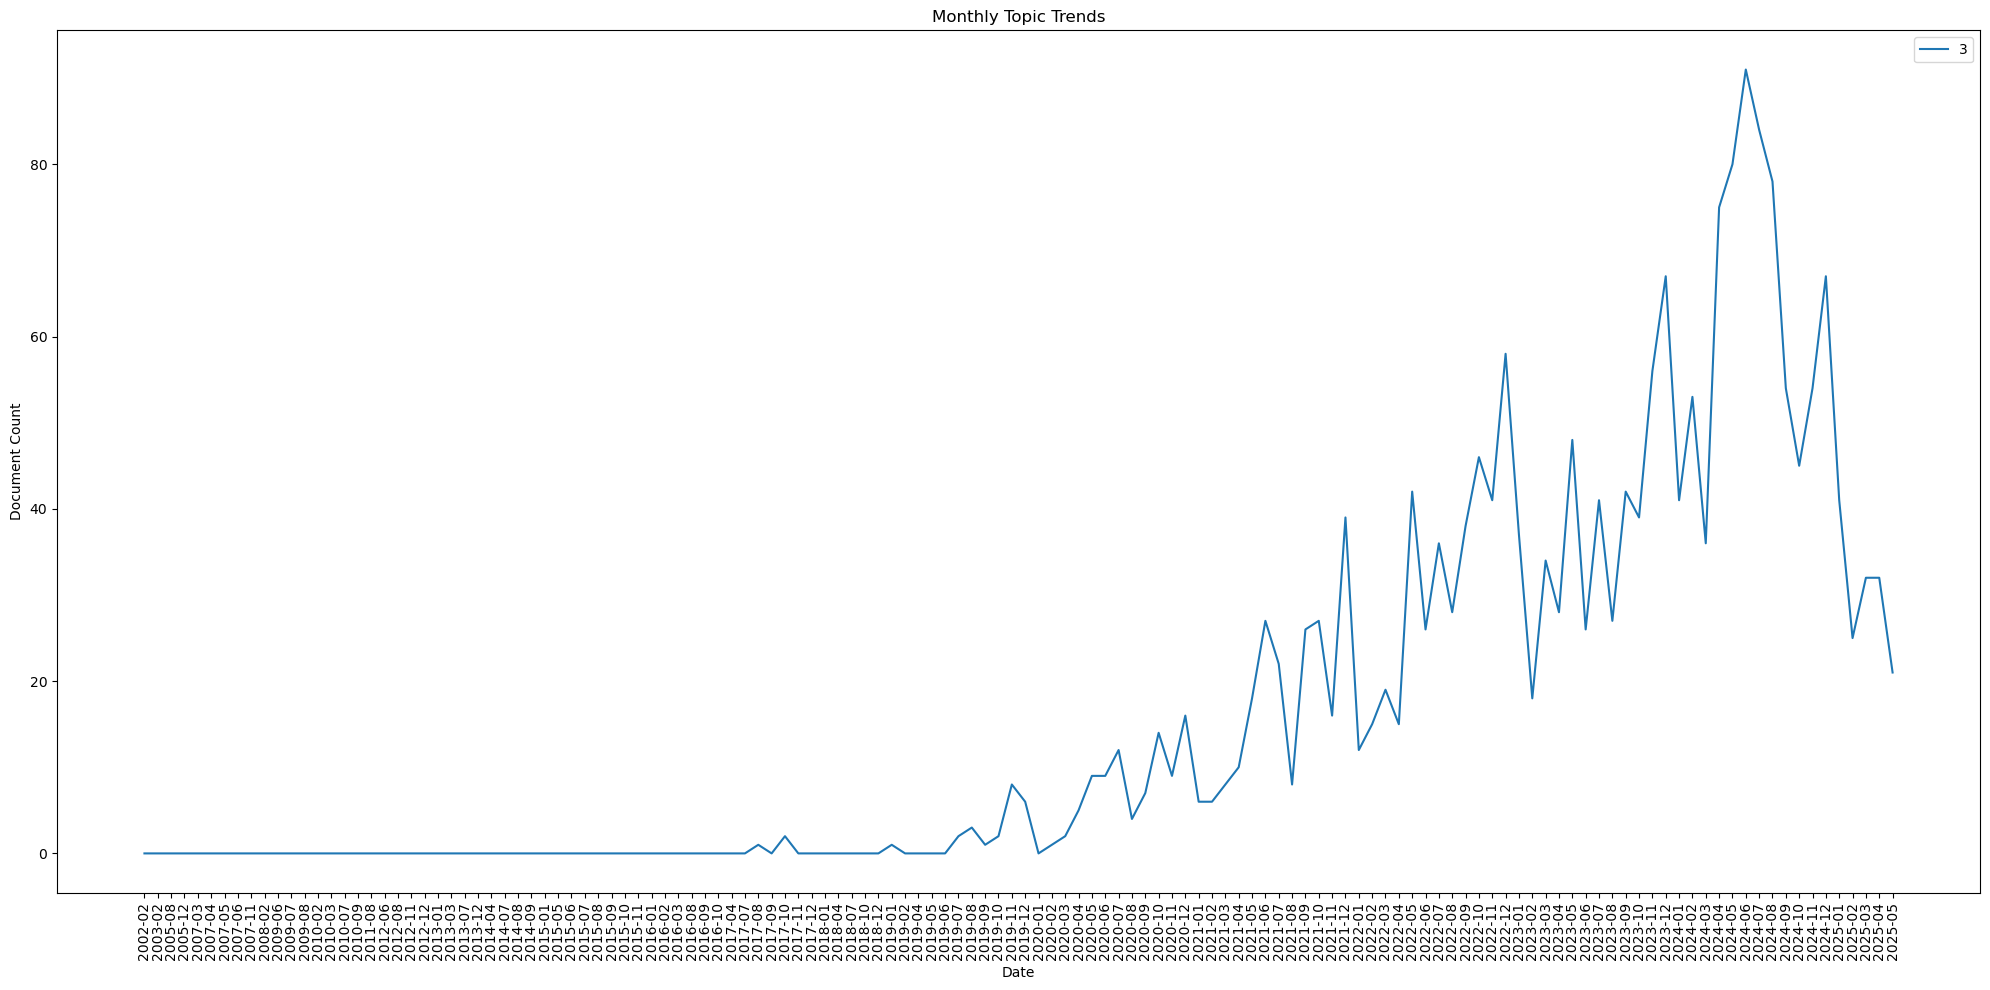

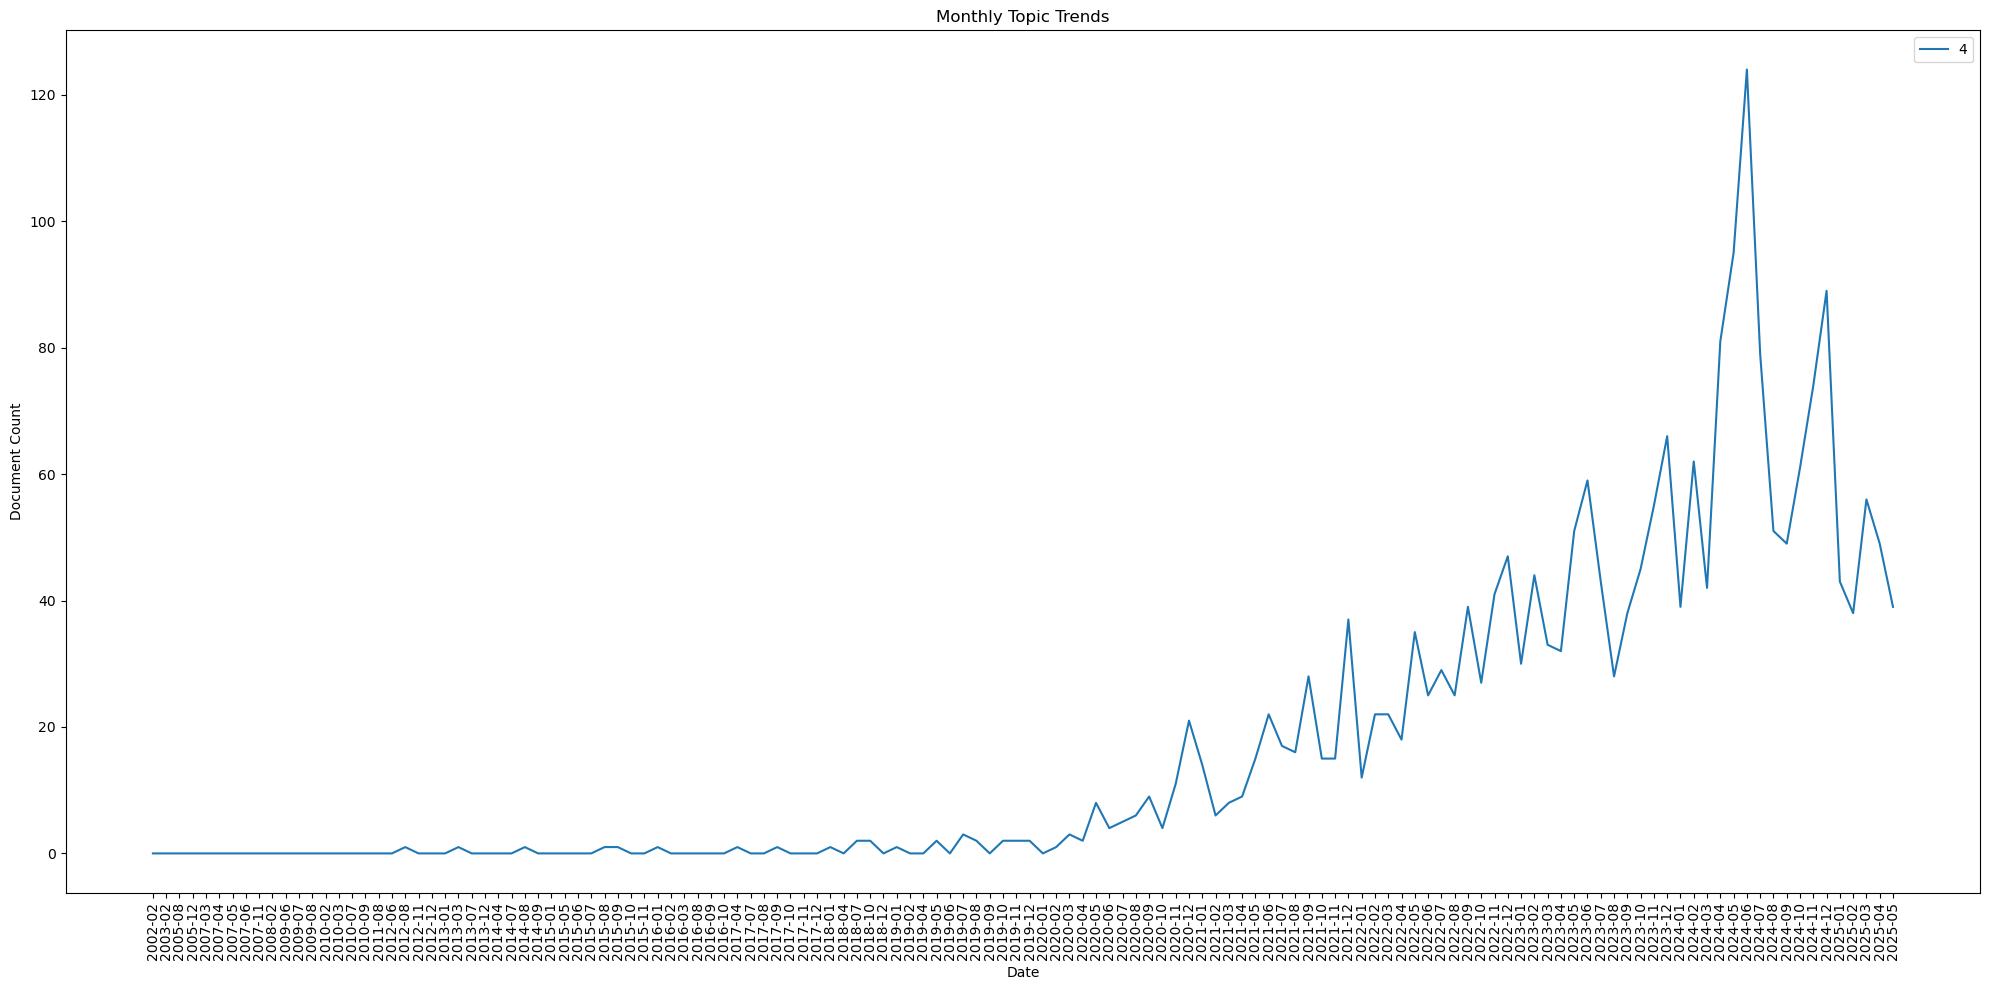

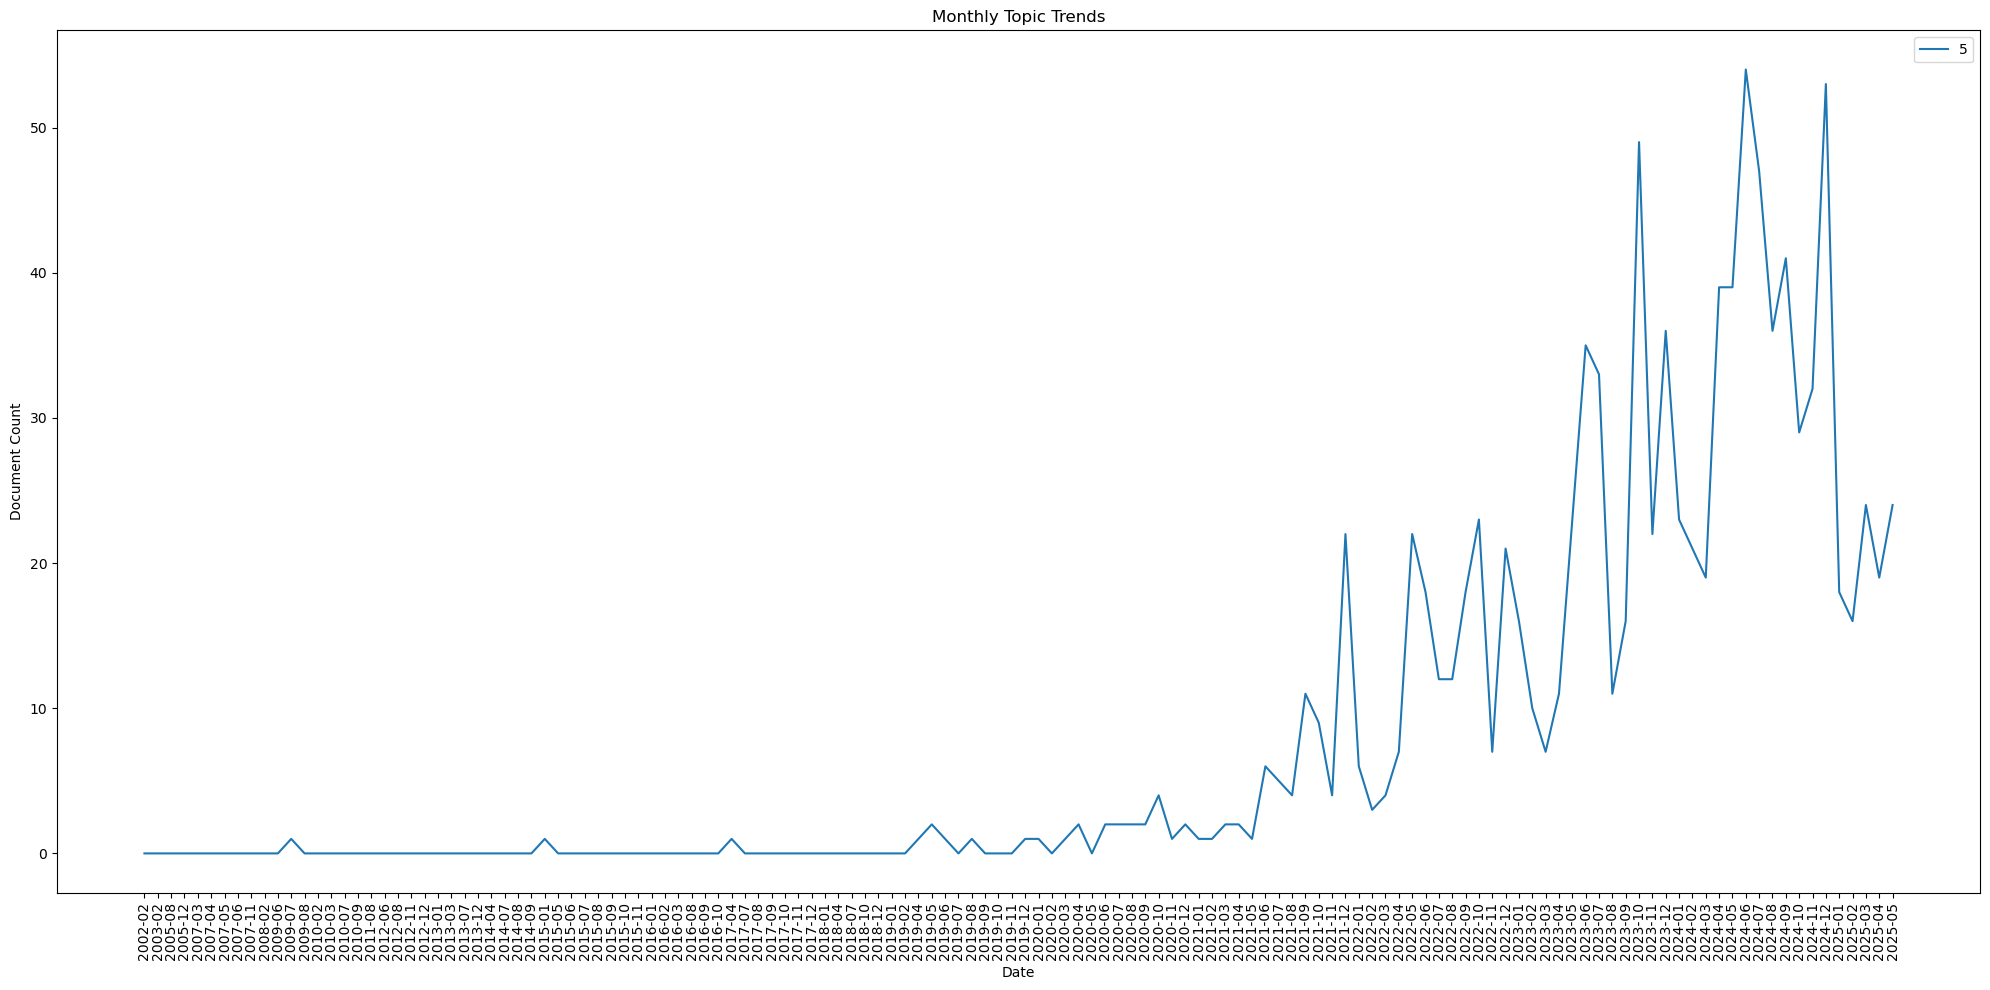

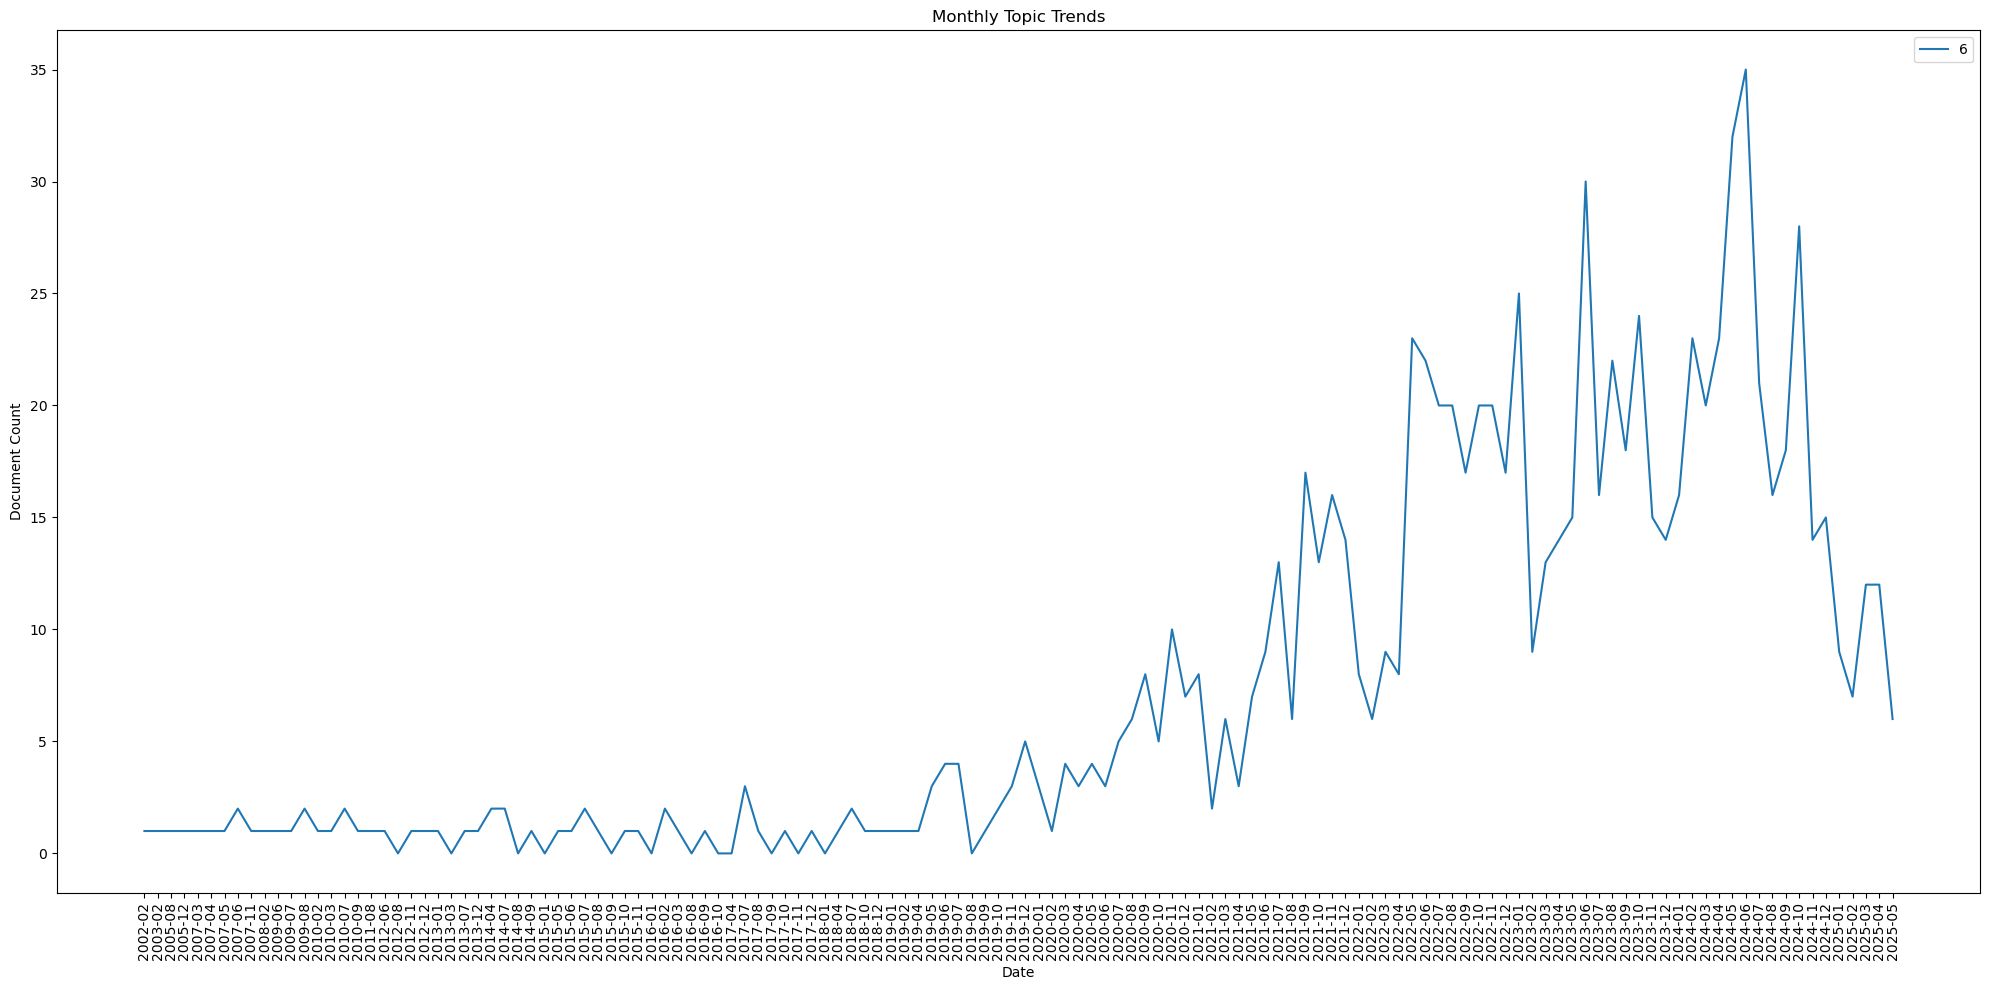

In [7]:
x, y, dic = make_data(PATH, TEST)
x_input, y_input = make_model_input(x, dic), make_model_input(y, dic)

model, vis_map = learn_visualize(x_input, dic)

x_topics, y_topics = topic_list(x_input, model, vis_map), topic_list(y_input, model, vis_map)

print_train_sample_topic_title(x, x_topics, SAMPLE)
print_test_topic_title(y, y_topics)

make_time_plot(x, x_topics)